# Predicting Frog Presence Using Climate Data



This notebook presents a class project focused on predicting frog presence in Southeastern Australia using climate data as a proxy for ecosystem health. We worked with raster .tiff files containing 14 climate variables (e.g., temperature, precipitation, vapor pressure), each representing the **median value across multiple years**. These variables were extracted and matched to frog observation points using latitude and longitude coordinates.

The goal was to build a machine learning model that can help monitor biodiversity in a **scalable and cost-effective** way. After preparing the data, we split it into training and test sets and trained a **Random Forest classifier**. We constructed a pipeline that includes **Min-Max Scaling**, and evaluated model performance using a **confusion matrix** and **classification report**.

In the final step, we applied the trained model to an unseen **validation dataset** (provided by the instructor but withheld during training), and exported the predictions to a CSV. These predictions were submitted for **F1 score evaluation** to assess real-world generalizability.


## Load In Dependencies


In [54]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Multi-dimensional arrays and datasets
import xarray as xr

# Geospatial data analysis
import geopandas as gpd

# Geospatial operations
import rasterio


# Feature Engineering
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Machine Learning
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay

# Others
import os
from tqdm import tqdm

In [55]:
# check if the dataset exists in the location 
import os
import pandas as pd

# Training data file path
file_path = "/Users/ethanmena/Documents/UTD/Grad School/3rd semester/Analytics Practicum/Group Project/Training_Data.csv"

# Check if the file exists
print("File exists:", os.path.exists(file_path))

File exists: True


## Response Variable


Before building the model, we need to load the frog presence dataset. We have curated data for the southeastern region of Australia. The dataset consists of geolocations (Latitude and Longitude), with an additional field for Occurrence Status.

In [56]:
# Load the training data from csv file and display the first few rows to inspect the data
#ground_df = pd.read_csv("Training_Data.csv")
#ground_df.head()

ground_df = pd.read_csv(file_path)
ground_df.head()

,Latitude,Longitude,Occurrence Status
0,-34.027900,150.771000,1
1,-34.821595,147.193697,1
2,-36.617759,146.882941,0
3,-37.470900,144.744000,1
4,-38.400153,145.018560,1


Here 1 indicate the frog presence and 0 indicate the non-presence of the frog at the given location.

In [57]:
#Check dataframe shape.
ground_df.shape

(6312, 3)

## Extracting Climatic variables from the TerraClimate sample GeoTiff image

For building a sample model in this demonstration notebook, we have downloaded a GeoTIFF file locally for the two-year period (from November 1, 2017, to November 1, 2019). The file is named TerraClimate_median_2yr.tiff. This GeoTIFF file contains values for 14 variables: precipitation (ppt), shortwave radiation (srad), maximum temperature (tmax), minimum temperature (tmin), vapor pressure (vap), wind speed (ws), actual evatransportation (aet), climatic water deficit (def), Palmer Drought Index (pdsi), reference evatransportation (pet), runoff (q), soil moisture at the end of the month (soil), snow water equivalent at the end of the month (soil), vapor pressure deficit (vpd).

 In the subsequent section, we will use this GeoTIFF file to extract the variable values for the geo-locations provided in the training dataset to create the features.

First, let’s visualize the variables in the downloaded GeoTIFF image.

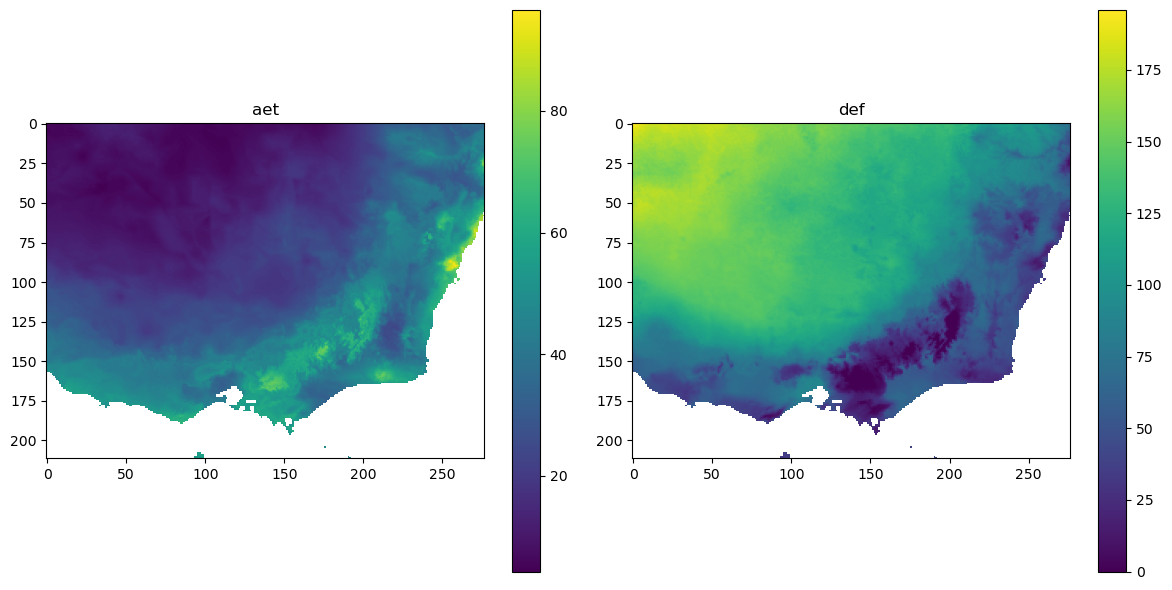

In [58]:
# Specify the path to your .tiff file
tiff_path = "/Users/ethanmena/TerraClimate_median_2yr.tiff"

# Reads and plots two climatic parameters srad and vap from the GeoTIFF file.
import rasterio

# Read the variables from the GeoTIFF file
with rasterio.open(tiff_path) as src1:
    variable1 = src1.read(1)  # variable [aet]
    variable2 = src1.read(2)  # variable [def]

# Plot the variables in a 2x2 grid
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Flatten the axes for easier indexing
axes = axes.flatten()

# Plot the first parameter (srad)
im1 = axes[0].imshow(variable1, cmap='viridis')
axes[0].set_title('aet')
fig.colorbar(im1, ax=axes[0])

# Plot the second parameter (vap)
im2 = axes[1].imshow(variable2, cmap='viridis')
axes[1].set_title('def')
fig.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()


In [59]:
# Create a function to extract the GeoTIFF  values and return them in a DataFrame.
def map_satellite_data(tiff_path, csv_path):

    # Load coordinate data
    df = pd.read_csv(csv_path)

    # Open the GeoTIFF file and read all 14 bands
    with rasterio.open(tiff_path) as dataset:
        # Read raster variables into numpy arrays following TerraClimate's documented order
        aet_data  = dataset.read(1)   # Actual Evapotranspiration
        def_data  = dataset.read(2)   # Climatic Water Deficit
        pdsi_data = dataset.read(3)   # Palmer Drought Severity Index
        pet_data  = dataset.read(4)   # Potential Evapotranspiration
        ppt_data  = dataset.read(5)   # Precipitation
        q_data    = dataset.read(6)   # Runoff (Streamflow)
        soil_data = dataset.read(7)   # Soil Moisture
        srad_data = dataset.read(8)   # Solar Radiation
        swe_data  = dataset.read(9)   # Snow Water Equivalent
        tmax_data = dataset.read(10)  # Maximum Temperature
        tmin_data = dataset.read(11)  # Minimum Temperature
        vap_data  = dataset.read(12)  # Vapor Pressure
        vpd_data  = dataset.read(13)  # Vapor Pressure Deficit
        ws_data   = dataset.read(14)  # Wind Speed

        # Generate coordinate grids (lon/lat) from raster bounds and resolution
        lon = np.linspace(dataset.bounds.left, dataset.bounds.right, dataset.width)
        lat = np.linspace(dataset.bounds.top, dataset.bounds.bottom, dataset.height)

        # Convert to xarray DataArrays
        variables = {
            "aet": aet_data, "def": def_data, "pdsi": pdsi_data, "pet": pet_data, 
            "ppt": ppt_data, "q": q_data, "soil": soil_data, "srad": srad_data,
            "swe": swe_data, "tmax": tmax_data, "tmin": tmin_data, "vap": vap_data,
            "vpd": vpd_data, "ws": ws_data
        }

        # Create DataArrays with lat/lon coordinates
        data_arrays = {
            name: xr.DataArray(data, coords=[("lat", lat), ("lon", lon)], dims=["lat", "lon"])
            for name, data in variables.items()
        }

    # Initialize lists to store extracted values
    extracted_values = {name: [] for name in variables.keys()}

    # Extract values for each coordinate in the CSV
    for _, row in tqdm(df.iterrows(), total=df.shape[0], desc="Extracting raster values"):
        target_lat, target_lon = row["Latitude"], row["Longitude"]

        for name, da in data_arrays.items():
            try:
                extracted_value = da.sel(lat=target_lat, lon=target_lon, method="nearest").values
            except KeyError:
                extracted_value = np.nan  # Assign NaN if the coordinate is out of bounds

            extracted_values[name].append(extracted_value)

    # Create DataFrame with proper column names
    extracted_df = pd.DataFrame(extracted_values)

    return extracted_df

In [60]:
# Mapping satellite data with training data.
final_data = map_satellite_data(tiff_path, file_path)

Extracting raster values: 100%|██████████| 6312/6312 [00:17<00:00, 362.06it/s]


In [61]:
#Display first 5 rows.
final_data.head(5)

,aet,def,pdsi,pet,ppt,q,soil,srad,swe,tmax,tmin,vap,vpd,ws
0,53.5,65.30000305175781,-4.5,115.5,49.7,2.5,16.700000762939453,200.7991485595703,0.0,23.899999618530273,12.59999942779541,1.2330000400543213,0.8100000023841858,3.5999999046325684
1,24.700000762939453,110.9000015258789,-3.8999998569488525,144.6999969482422,25.900000000000002,1.3,2.5,218.40399169921875,0.0,24.5,10.899999618530273,0.9420000314712524,1.3299999237060547,3.0999999046325684
2,51.29999923706055,28.200000762939453,-3.799999952316284,115.0999984741211,69.9,3.5,68.80000305175781,204.00003051757812,0.0,21.399999618530273,8.09999942779541,0.9420000314712524,0.7799999713897705,3.1999998092651367
3,41.0,67.30000305175781,-4.699999809265137,120.70000457763672,45.0,2.3000000000000003,11.300000190734863,204.400146484375,0.0,20.19999885559082,8.0,0.9510000348091125,0.699999988079071,4.400000095367432
4,58.900001525878906,29.5,-4.799999713897705,109.5,71.10000000000001,3.6,43.0,189.20396423339844,0.0,18.899999618530273,9.899999618530273,1.096000075340271,0.5,5.599999904632568


## Joining the predictor variables and response variables


Now that we have extracted our predictor variables, we need to join them onto the response variable . We use the function combine_two_datasets to combine the predictor variables and response variables.The concat function from pandas comes in handy here.

In [62]:
# Combine two datasets vertically (along columns) using pandas concat function.
def combine_two_datasets(dataset1,dataset2):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined 
    dataset2 - Dataset 2 to be combined
    '''
    
    data = pd.concat([dataset1,dataset2], axis=1)
    return data

In [63]:
# Combining ground data and final data into a single dataset.
final_data = combine_two_datasets(ground_df,final_data)
final_data.head()

,Latitude,Longitude,Occurrence Status,aet,def,pdsi,pet,ppt,q,soil,srad,swe,tmax,tmin,vap,vpd,ws
0,-34.027900,150.771000,1,53.5,65.30000305175781,-4.5,115.5,49.7,2.5,16.700000762939453,200.7991485595703,0.0,23.899999618530273,12.59999942779541,1.2330000400543213,0.8100000023841858,3.5999999046325684
1,-34.821595,147.193697,1,24.700000762939453,110.9000015258789,-3.8999998569488525,144.6999969482422,25.900000000000002,1.3,2.5,218.40399169921875,0.0,24.5,10.899999618530273,0.9420000314712524,1.3299999237060547,3.0999999046325684
2,-36.617759,146.882941,0,51.29999923706055,28.200000762939453,-3.799999952316284,115.0999984741211,69.9,3.5,68.80000305175781,204.00003051757812,0.0,21.399999618530273,8.09999942779541,0.9420000314712524,0.7799999713897705,3.1999998092651367
3,-37.470900,144.744000,1,41.0,67.30000305175781,-4.699999809265137,120.70000457763672,45.0,2.3000000000000003,11.300000190734863,204.400146484375,0.0,20.19999885559082,8.0,0.9510000348091125,0.699999988079071,4.400000095367432
4,-38.400153,145.018560,1,58.900001525878906,29.5,-4.799999713897705,109.5,71.10000000000001,3.6,43.0,189.20396423339844,0.0,18.899999618530273,9.899999618530273,1.096000075340271,0.5,5.599999904632568


In [64]:
final_data.shape

(6312, 17)

## Removing duplicates::
Identical or duplicate entries are removed based on specific columns, in our case ['srad','vap', 'tmax', 'tmin', 'ppt', 'ws', 'aet','def','pdsi','pet','q','soil','swe','vpd']. This ensures that the dataset is not biased or skewed by repetitive data, allowing the model to train on unique, relevant observations.

In [65]:
# Remove duplicate rows from the DataFrame based on specified columns and keep the first occurrence
columns_to_check = ['srad','vap', 'tmax', 'tmin', 'ppt', 'ws', 'aet','def','pdsi','pet','q','soil','swe','vpd','Occurrence Status']
for col in columns_to_check:
    # Check if the value is a numpy array and has more than one dimension
    final_data[col] = final_data[col].apply(lambda x: x.item() if isinstance(x, np.ndarray) and x.ndim == 0 else x)

# Now remove duplicates
final_data = final_data.drop_duplicates(subset=columns_to_check, keep='first')
final_data.shape


(5285, 17)

In [66]:
# Resetting the index of the dataset
final_data=final_data.reset_index(drop=True)

In [67]:
final_data.head()

,Latitude,Longitude,Occurrence Status,aet,def,pdsi,pet,ppt,q,soil,srad,swe,tmax,tmin,vap,vpd,ws
0,-34.027900,150.771000,1,53.500000,65.300003,-4.5,115.500000,49.7,2.5,16.700001,200.799149,0.0,23.900000,12.599999,1.233,0.81,3.6
1,-34.821595,147.193697,1,24.700001,110.900002,-3.9,144.699997,25.9,1.3,2.500000,218.403992,0.0,24.500000,10.900000,0.942,1.33,3.1
2,-36.617759,146.882941,0,51.299999,28.200001,-3.8,115.099998,69.9,3.5,68.800003,204.000031,0.0,21.400000,8.099999,0.942,0.78,3.2
3,-37.470900,144.744000,1,41.000000,67.300003,-4.7,120.700005,45.0,2.3,11.300000,204.400146,0.0,20.199999,8.000000,0.951,0.70,4.4
4,-38.400153,145.018560,1,58.900002,29.500000,-4.8,109.500000,71.1,3.6,43.000000,189.203964,0.0,18.900000,9.900000,1.096,0.50,5.6


In [68]:
print(final_data.columns)


Index(['Latitude', 'Longitude', 'Occurrence Status', 'aet', 'def', 'pdsi',
       'pet', 'ppt', 'q', 'soil', 'srad', 'swe', 'tmax', 'tmin', 'vap', 'vpd',
       'ws'],
      dtype='object')


Here we select the columns required for our model building exercise. We will consider only 14 variables from TerraClimate from the final data as our predictor variables. It does not make sense to use latitude and longitude as predictor variables, as they do not have any direct impact on predicting the presence of frog.

In [69]:
# Retaining only the columns for srad, vap and Occurrence Status in the dataset.
final_data=final_data[['srad','vap', 'tmax', 'tmin', 'ppt', 'ws', 'aet','def','pdsi','pet','q','soil','swe','vpd','Occurrence Status']]

#Create a copy of data.
model_data = final_data.copy()

#Summary statistics of data.
model_data.describe()

,srad,vap,tmax,tmin,ppt,ws,aet,def,pdsi,pet,q,soil,swe,vpd,Occurrence Status
count,5285.000000,5285.000000,5285.000000,5285.000000,5285.000000,5285.000000,5285.000000,5285.000000,5285.000000,5285.000000,5285.000000,5285.000000,5285.000000,5285.000000,5285.000000
mean,206.579565,1.001957,21.822384,9.201741,45.797824,3.854488,41.173170,69.175309,-4.157729,121.776028,2.362252,22.020000,0.000132,0.840184,0.532640
std,12.600953,0.124070,2.788198,2.210589,18.904902,0.781725,14.102955,36.623188,0.809175,17.385434,1.313312,31.490164,0.005995,0.344911,0.498981
min,177.800842,0.564000,10.000000,0.900000,10.100000,2.600000,9.600000,0.000000,-6.500000,78.599998,0.500000,0.300000,0.000000,0.280000,0.000000
25%,197.198166,0.938000,19.799999,7.700000,32.100000,3.200000,31.300001,41.900002,-4.700000,108.900002,1.600000,2.800000,0.000000,0.580000,0.000000
50%,205.000305,0.978000,21.299999,9.099999,43.300000,3.600000,41.299999,63.600002,-4.300000,116.400002,2.200000,10.800000,0.000000,0.710000,1.000000
75%,216.299408,1.050000,23.900000,10.700000,57.100000,4.300000,50.500000,96.300003,-3.600000,133.600006,2.900000,26.600000,0.000000,1.060000,1.000000
max,236.496948,1.468000,28.199999,14.799999,127.800000,7.050000,96.599998,148.400009,-2.300000,164.699997,23.900000,210.900009,0.400000,1.730000,1.000000


In [70]:
# Define features and target.
x = model_data.drop(columns=["Occurrence Status"])  # Exclude the target column
y = model_data["Occurrence Status"].values

## Building and Training the Machine Learning Pipeline::


In this section, we define a machine learning pipeline that includes both preprocessing and model training steps. First, we specify the numerical features (srad and vap) and set up a preprocessing pipeline (num_transformer). This pipeline applies a SimpleImputer to handle any missing values by replacing them with the median, followed by a MinMaxScaler to normalize the data. Then, we combine this preprocessing step using ColumnTransformer. Next, we define a Random Forest Model, which will be trained on the processed data. The entire workflow, including preprocessing and model fitting, is encapsulated in a Pipeline. We then split the dataset into training and test sets, using 97.5% of the data for training and 2.5% for testing (as this we need more data for our training, done after considering the results of the validation feedback). Finally, we train the pipeline using the training data. This ensures that preprocessing and model fitting occur in a streamlined and consistent manner.

In [71]:
# Import necessary libraries
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import joblib

# Define features to be used
features = ['srad','vap', 'tmax', 'tmin', 'ppt', 'ws', 'aet','def','pdsi','pet','q','soil','swe','vpd']

# Define preprocessing steps: Imputation and Scaling
transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  # Fill missing values with the median
    ("scaler", MinMaxScaler())                       # Scale numerical features to 0-1 range
])

# Combine preprocessing steps with ColumnTransformer
preprocessor = ColumnTransformer([
    ("num", transformer, features)
])

# Define the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Create the full pipeline including preprocessing and the classifier
pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", model)
])

# Split dataset into training and testing sets

# here we have made the test data as small as 2.5% of the total because we had already tested the data before and 
# wanted more data for training the model to achieve a higher prediction capablities.
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.025, stratify=y, random_state=42)

# Train the pipeline with the training data
pipeline.fit(X_train, y_train)

# Save the trained model using joblib
joblib.dump(pipeline, "random_forest_pipeline.pkl")
print("Pipeline saved successfully!")



Pipeline saved successfully!


## Model Evaluation::

For evaluation, we will use the classification report, which provides key metrics like precision, recall, F1-score, and accuracy for each class. These metrics help assess how well the model is predicting frog presence and absence (Occurrence Status)

### Training data

In-Sample Performance:
              precision    recall  f1-score   support

           0       0.97      0.92      0.95      2408
           1       0.94      0.98      0.96      2744

    accuracy                           0.95      5152
   macro avg       0.95      0.95      0.95      5152
weighted avg       0.95      0.95      0.95      5152



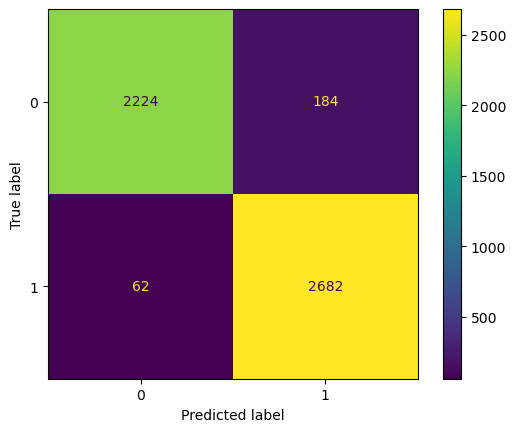

In [72]:
# Make predictions on the training data (In-sample predictions)
insample_predictions = pipeline.predict(X_train)
print("In-Sample Performance:")
print(classification_report(y_train, insample_predictions))

# Display the confusion matrix for in-sample predictions
ConfusionMatrixDisplay(confusion_matrix(y_train, insample_predictions)).plot()

In [73]:
# Make predictions on the test data (Out-of-sample predictions)
outsample_predictions = pipeline.predict(X_test)
print("Out-of-Sample Performance:")
print(classification_report(y_test, outsample_predictions))

Out-of-Sample Performance:
              precision    recall  f1-score   support

           0       0.71      0.71      0.71        62
           1       0.75      0.75      0.75        71

    accuracy                           0.73       133
   macro avg       0.73      0.73      0.73       133
weighted avg       0.73      0.73      0.73       133



### Test data

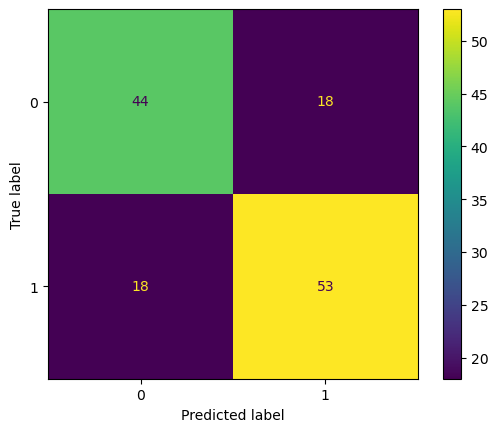

In [74]:
# Display the confusion matrix for out-of-sample predictions
ConfusionMatrixDisplay(confusion_matrix(y_test, outsample_predictions)).plot()


## Model Validation on a New Location

Here we validate the model on the dataset of a different location.

In [75]:
# Load the validation dataset
test_file = pd.read_csv('/Users/ethanmena/Validation_Template.csv')
print("Validation Data Shape:", test_file.shape)

Validation Data Shape: (2000, 2)


In [76]:
# Map satellite data with the validation data
final_val_data = map_satellite_data(tiff_path,'/Users/ethanmena/Validation_Template.csv')
print("Mapped Validation Data:")
print(final_val_data.head())

Extracting raster values: 100%|██████████| 2000/2000 [00:05<00:00, 369.85it/s]

Mapped Validation Data:
                  aet                 def                pdsi  \
0   39.10000228881836  51.900001525878906  -4.599999904632568   
1   48.79999923706055                23.5  -4.799999713897705   
2  24.399999618530273               115.0  -4.400000095367432   
3   37.79999923706055                63.5  -4.299999713897705   
4  24.700000762939453               113.5  -4.400000095367432   

                  pet                 ppt                   q  \
0  105.80000305175781                40.1                 2.0   
1  108.20000457763672                62.6                 3.1   
2  139.60000610351562  24.900000000000002  1.2000000000000002   
3   118.0999984741211                39.5                 2.0   
4  138.10000610351562                25.5                 1.3   

                 soil                srad  swe                tmax  \
0  11.300000190734863  205.69839477539062  0.0                21.5   
1   29.30000114440918    197.801513671875  0.0        

In [77]:
# Load the saved model and predict on the validation data
loaded_pipeline = joblib.load("random_forest_pipeline.pkl")
final_predictions = loaded_pipeline.predict(final_val_data)

# Combine predictions into a DataFrame
submission_df = pd.DataFrame({
    'Latitude': test_file['Latitude'].values,
    'Longitude': test_file['Longitude'].values,
    'Occurrence Status': final_predictions
})

# Display the resulting DataFrame
print("Submission DataFrame:")
print(submission_df.head())

# Save the predictions to a CSV file
submission_df.to_csv("Predicted_Data.csv", index=False)
print("Predictions saved to 'Predicted_Data.csv' successfully!")

Submission DataFrame:
    Latitude   Longitude  Occurrence Status
0 -33.121788  150.320746                  1
1 -36.592011  148.172262                  0
2 -35.455100  146.693465                  0
3 -33.076261  149.547177                  0
4 -35.529729  146.627272                  0
Predictions saved to 'Predicted_Data.csv' successfully!
